In [1]:
import networkx as nx
import re
import json
import os
from random import choice
import rdflib
from os.path import exists
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl
import matplotlib.pyplot as plt
from pyvis.network import Network
import pandas as pd



In [2]:
def parseData(dataset,outputfile):
    lst2=[]
    with open(dataset,encoding="utf8") as f:
        for line in f:
            lst2.append(line.strip())

    lst22=[]
    for i in range(0,len(lst2)):
        new= lst2[i].strip()
        sub = re.split('\s\.', new)
        if sub[-1]=='':
            sub=sub[0:len(sub)-1]

        if len(sub)>1:

            for j in range(0,len(sub)):                       
                if len(sub[j])!=0:

                    if j==0:
                        lst22.append(sub[j]+' .')

                    if sub[j][-1] !=';' and sub[j][-1] !=',':
                        lst22.append(sub[j]+' .')

                    else:
                        lst22.append(sub[j])
        else:
            if len(sub)>0:
                if sub[0][-1]!=';' and sub[0][-1]!=',':
                    lst22.append(sub[0]+' .')
                else:
                    lst22.append(sub[0])


    lst3=[]
    for i in range(5,len(lst22)):

        if i == 5:
            first = lst22[i].split(' ')[0]

        if lst22[i].split(' ')[0] == first:
            lst3.append(lst22[i])
        else:
            lst3.append(first+' '+lst22[i])

        if(lst22[i][-1]=='.' and i!=len(lst22)-1):    

            first = lst22[i+1].split(' ')[0]

    lst4=[]
    for i in range(len(lst3)):
        if '[' in lst3[i]:
            lst4.append(lst3[i]+' '+lst3[i+1])
        else:
            lst4.append(lst3[i])
            
    
            
    if os.path.exists('./data/items.txt'):
        os.remove("./data/items.txt") 
        
    print('SAVING ITEMS')
    with open('./data/items.txt', 'w', encoding="utf-8") as f:
        for line in lst4:
            f.write(line+'\n')

    with open('./data/items.txt', encoding="utf-8") as f:
        lines = f.readlines()


    lst5=[]
    com = 0
    for i in range(0,len(lines)):

        if lines[i].strip('\n')[-1] ==',' and i+1 != com:        
            n=lines[i].strip('\n')

            for j in range(i+1,len(lines)):
                n = n+' '+lines[j].strip('\n')
                if lines[j].strip('\n')[-1]==';':
                    lst5.append(n)
                    com=j

                    break
        else:
            n=lines[i].strip('\n')
            lst5.append(n)

    with open(outputfile, 'w', encoding="utf-8") as f:
        for line in lst5:
            f.write(line+'\n')

In [3]:
# parseData('./data/nisv_cat_daan_sdo_20230504.ttl','./data/items3.txt')

In [7]:
# Function takes filename as input in text format and 
# returns a dictionary where the key is the subject of the triples and the values are all 
# the properties with objects


def getDic(filename):
    print('Loading data')
    with open(filename, encoding="utf-8") as f:
        lines = f.readlines()

    lines=  list(set(lines))

    ddic={}
    for i in lines:
        i=i.strip('\n')
        sub=i.split(' ')[0].strip()
    #     print(sub)
        if sub not in ddic:
            ddic[sub]=[' '.join(i.split(' ')[1:])]
        else:
    #         print(i,ddic[sub])
            items=' '.join(i.split(' ')[1:])
    #         print(items,' '.join(ddic[sub]),'\n')
    #         if items not in ' '.join(ddic[sub]):
            ddic[sub].append(items)
    return ddic

# This function takes a list of tuples as input. The list of tuples are in the order of 
# (subj, subj class, obj, obj class, property connecting subj and obj). Using the input, a graph is generated with the 
# required labels (attributes) of nodes and edges


def addNodes(lst):
    G = nx.Graph()
    for i in lst:
        subj = i[0]
        subj_class = i[1]
        obj=i[2]
        obj_class=i[3]
        edge_label=i[4]
        G.add_node(subj, Class=subj_class)
        G.add_node(obj, Class=obj_class)
        G.add_edge(subj, obj, Label=edge_label)
    
    return G

# This function is used to extract quotes within strings. This is helpful in case of extracting labels of entities 
# so that they are human readable 

def getMatch(text):
    matches = re.findall(r'"(.+?)"',text)
    return ",".join(matches)


# This function takes a dic and a property (with their subj obj classes as input) and basically extracts all the 
# relevent tripes of the property. Transforms the instances in a tuple structure (to avoid repetition in case any) and finally 
# saves them all in a list. This list is then passed to the 'addNodes' function to generate a graph.

def genSubGraph(ddic,l):
    nodes=set()
    for key,value in ddic.items():
        for i in value:
            if l[2]==i.split(' ')[0]:
#                     Here there is a special condition here which is looking at location created property. 
#                     This is present here only to cater to the NISV dataset since it as yet to properly define locations in their 
#                     dataset.
                if l[2]=='sdo:locationCreated':
                    loc= getMatch(i)
                    loc= loc.split(' ')[0]
                    nodes.add((key,l[0],loc,l[1],l[2]))
                if l[2]=='sdo:datePublished':
                    dat=getMatch(i).split('-')[0]
                    nodes.add((key,l[0],dat,l[1],l[2]))
                    
                else:
                    for j in i.split(' '):
                        if 'gtaa:' in j:
                            nodes.add((key,l[0],j,l[1],l[2]))
                                

    nodes=list(nodes)
#     print(nodes[0:1000])
    return addNodes(nodes)



# This function takes a list of properties (with their classes defined) and returns a dict of subgraphs for each of the property 
# in the list. The key is the name of the property so we keep track of the subgraph types

def genGraph(ddic,prop):
    print('Generating sub-graphs')
    subg={}
    for p in prop:
        s=genSubGraph(ddic,p)
        filename=p[2].split(':')[1]
        subg[filename]=s
#         subg.append([s,p[2]])
    
    return subg


# Here is where we take the list of subgraph and generate the eigenvector centrality score (importance according to important links)
# for each of the nodes in each of the subgraphs iteratively. 

# The documentation for the function performing this computation can be found here:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html

# This function returns a list of lists. The first item for each list is the name of the property and the second item 
# is the dictionary of scores. The key are the nodes and the value are the score generated by the computation

def getScore(subg):
    print('Calculating scores')
    score={}
    for k,v in subg.items():
        eigen = nx.eigenvector_centrality(v,max_iter=1500,tol=1.0e-5)
       
        score[k]=getCycleScore(v,eigen)
        
    return score


# Enmpties the directory of score we can write new score values if needed
def emptyScoreDir():
    dr = os.listdir('./score')
    for file in dr:
        os.remove('./score/'+file)
  

# saves all the scores in the score directory (after emptying) in the form of json jumps. These are files are named
# after each of the property we are using.

def saveScores(s):
    print('Saving scores')
    emptyScoreDir()
    for k,v in s.items():
#         print(k)
        out_file = open("./score/"+k+".json", "w")
        json.dump(v, out_file)
        out_file.close()

                
def getCycleScore(graph,scores):
   
#     print('cycles for',graph)
    
#     for k,v in scores.items():
#         if v>highest:
#             highest=v
            
#     percent20 = highest*0.05
    
    
    s=0
    for k,v in scores.items():
        s=s+v
    average = s/len(scores)
    
    percentavg = average
#     percentavg = average*0.20

    
    cycles_list=[]
    cycles  = nx.cycle_basis(graph)

    for i in cycles:
        for j in i:
            cycles_list.append(j)

    final_dic={}
    cycles_list=list(set(cycles_list))
    
    for i in cycles_list:
        final_dic[i]=percentavg
    
    for k,v in scores.items():
  
        if k in final_dic:
#             final_dic[k]=final_dic[k]+v
            final_dic[k]=final_dic[k]+v*0.80
    
        else:
            final_dic[k]=v
            
    the_last_dic={}
    
    highest_2=0
    lowest=1000000000
    for k,v in final_dic.items():
        if v>highest_2:
            highest_2=v
        
        if v<lowest:
            lowest=v
    
    print(highest_2,lowest)
    max_min=highest_2-lowest
    
    for k,v in final_dic.items():
        
        the_last_dic[k]=(v-lowest)/max_min
    
    return the_last_dic
        

def getAverage(filename):
    
    f = open('./score/'+filename) 

    data = json.load(f) 
    s=0
    for k,v in data.items():
        s=s+v
    #     print(k,v)
    average = s/len(data)
    newD = {}
    for k,v in data.items():
        newD[k]=v/average

    return newD

def joinGraph(G):
    print('Producing final graph')
    lst=[]
    av=[]
    
    if os.path.exists('./score/final_score.json'):
        os.remove('./score/final_score.json')
        
    dr = os.listdir('./score')
    for file in dr:
        avg=getAverage(file)
        filename = file.split('.')[0]
        graph = G[filename]
        lst.append(graph)
        av.append(avg)
        
#     I can do this in terateive fasion and combine graphs 2 at a time as well as their scores
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.operators.binary.compose.html#networkx.algorithms.operators.binary.compose
    final= nx.compose_all(lst)
#     print(len(final))
    
    final_score={}
    for node in list(final.nodes(data=True)):
        sc=0
        nname=node[0]
        for d in av:
            if d.get(nname) is not None:
                sc = sc+ d[nname]
            else:
                sc= sc+0
                
        final_score[nname]=sc
    
    
    out_file = open("./score/final_score.json", "w")
    json.dump(final_score, out_file)
    out_file.close()
        

        
    nx.set_node_attributes(final,final_score,name='score')
    final.remove_node('')
#     final.remove_node('.."^^xsd:string')
    return final


def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def getName(inp):
    
    if has_numbers(inp) == False:
        return inp
    
    if inp.isnumeric():
        return inp
    
    inp = inp.strip()
    inp = inp.strip(',')
    inp = inp.strip('.')
    wikidata_endpoint = "https://cat.apis.beeldengeluid.nl/sparql"

    my_SPARQL_query = """
    PREFIX sdo: <https://schema.org/>
    PREFIX gtaa: <http://data.beeldengeluid.nl/gtaa/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT ?name  
    WHERE
    {
    OPTIONAL { """+inp+"""  sdo:name ?name}
    OPTIONAL { """+inp+"""  skos:prefLabel ?name}
    } 
    """
    sparql_wd = SPARQLWrapper(wikidata_endpoint)
    sparql_wd.setQuery(my_SPARQL_query)
    sparql_wd.setReturnFormat(JSON)
    results = sparql_wd.query().convert()
    for result in results["results"]["bindings"]:
        return result['name']['value']

def doit(text):      
  
  matches = re.findall(r'"(.+?)"',text)
  # matches is now ['String 1', 'String 2', 'String3']
  return ",".join(matches)


def getData(cw,F,ddic,visited,classname=None):
#     print('current node:',cw,getName(cw),'\n')
    DG=nx.Graph()
    
    print('Concert :\n'+getName(cw)+'\n')
#     print('current : \n',getName(cw),'\n')
    newdic={}
    for k,v in F[cw].items():
        v=v['Label']
        if v not in newdic:
            newdic[v]=[k]
        else:
            newdic[v].append(k)
    
    for key,value in newdic.items():
        print(key)
        for i in value:
#             print(i,'|',getName(i))
            print(getName(i))
            DG.add_edge(getName(cw), getName(i))
        print('\n')
    
    high=getHighScore(F[cw],F)
    
    if classname==None:
        final = choice(high)[0]  
        for c in high:
            if c[0] not in visited:
                final = c[0]
                break
    else:
        classes =[]
        for cl in high:
            f_class = F.nodes[cl[0]]['Class']
            if f_class == classname:
                classes.append((cl[0],cl[1]))

#         print("HIGH SCORES",classes)
    
        if len(classes)>0:
            final = choice(classes)[0]  
        #     final = choice(high)[0]
            for c in classes:
                if c[0] not in visited:
                    final = c[0]
                    break
    
        else:
            final = choice(high)[0]  
        #     final = choice(high)[0]
            for c in high:
                if c[0] not in visited:
                    final = c[0]
                    break
        
            
#     print('highest = ',high,'|',getName(high),'\n')
#     print('highest = ',getName(final),'\n')
    print('The most important entity seems to be '+getName(final)+' which was also was part of:','\n')
    return [final,DG]
    
    
# we can get a list of all the scores sorted and we can return that list

# we can maintain 2 lists. One of the ones which had the highest score and the other with all the nodes we have encountered.
# So if we finish all the high score ones we can jump into other

def getHighScore(nbors,F):
    sdic={}
    for k,v in nbors.items():
        sdic[k.strip(',')]=F.nodes[k]['score']
    sort = sorted(sdic.items(), key=lambda x:x[1],reverse=True)
   
    return sort
    

def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False):

    # import
    from pyvis import network as net
    
    # make a pyvis network
    pyvis_graph = net.Network(notebook=notebook)
    
    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(str(node),**node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(str(source),str(target),**edge_attrs)
        
    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()
    
    # return and also save
    return pyvis_graph.show(output_filename)

    
def getChains(l,F,ddic,visited,classname=None,start_node=None):
#     DG = nx.Graph()
#     print('Visualizing chains')
    n=0
    DG_l=[]
    while(n!=l):
        if n==0:
            if start_node==None:
                high={}
                for node in F:
                    high[node]=F.nodes[node]['score']
                sort = sorted(high.items(), key=lambda x:x[1],reverse=True)
                top30 = sort[0:50]
                
                while True:
                    start=choice(top30)[0]
                    if start not in visited:
                        break
            else:
                start =  start_node
            
        if (F.nodes[start]['Class'] == 'Creative Work'):
            cw=start
            start =getData(cw,F,ddic,visited,classname)
            DG_l.append(start[1])
            start=start[0]
            visited.append(start)
            

        else:
            nbors=F[start]
            high=getHighScore(nbors,F)
            cw = high[0][0]
            for c in high:
                if c[0] not in visited:
                    cw = c[0]
                    break

            start =getData(cw,F,ddic,visited,classname)
            visited.append(cw)
            DG_l.append(start[1])
            start=start[0]
            visited.append(start)
            
            
        n=n+1
    ff=nx.compose_all(DG_l)
    

    
    return [visited,ff]



def getPath(F,node1,node2):
    if nx.has_path(F,node1,node2):        
        path = nx.shortest_path(F,node1,node2)
        for i in range(len(path)):
            print(getName(path[i]))
            if i!=len(path)-1:
                print('connected by',F.get_edge_data(path[i],path[i+1])['Label'],'with:')
            
    else:
        print('There is no path between the 2 nodes')
        
        
def getNarratives():
    v=[]
    for i in range(10):
        print("---------------------- Narrative #",i+1,'----------------------------')
        res = getChains(4,F,ddic,v)
        v.append(res[0])
        ff=res[1]
        draw_graph3(ff,True,'Narrative '+str(i+1)+'.html')
        options = {
            "font_size": 6,
            "node_size": 60,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }
        nx.draw_networkx(ff, **options)

        # Set margins for the axes so that nodes aren't clipped
        ax = plt.gca()
        ax.margins(0.20)
        plt.axis("off")
        plt.show()



In [8]:
# Here is when we start calling our functions:
    
# ddic = getDic('./data/items2.txt')
# # # ls = [['Creative Work','Person','sdo:byArtist'],['Creative Work','Organization','sdo:provider'],['Creative Work','Thing','sdo:genre'],['Creative Work','Person','sdo:creator'],['Creative Work','Person','sdo:mentions'],['Creative Work','Location','sdo:locationCreated'],['Creative Work','Organization','sdo:productionCompany']]
# # # ls = [['Creative Work','Person','sdo:byArtist'],['Creative Work','Organization','sdo:provider'],['Creative Work','Thing','sdo:genre'],['Creative Work','Organization','sdo:productionCompany'],['Creative Work','Person','sdo:creator']]

imp_prop = [['Creative Work','Person','sdo:byArtist'],['Creative Work','Organization','sdo:provider'],['Creative Work','Thing','sdo:genre'],['Creative Work','Location','sdo:locationCreated'],['Creative Work','Organization','sdo:productionCompany'],['Creative Work','Person','sdo:creator'],['Creative Work','Date','sdo:datePublished']]
# imp_prop_test = [['Creative Work','Date','sdo:datePublished']]

G=genGraph(ddic,imp_prop)

s = getScore(G)
saveScores(s)


# people_prop = [['Creative Work','Person','sdo:byArtist'],['Creative Work','Person','sdo:creator'],['Creative Work','Person','sdo:mentions']]
# H=genGraph(ddic,people_prop)
F=joinGraph(G)
# PersonGraph=joinGraph(H)

Generating sub-graphs
Calculating scores
cycles for Graph with 231859 nodes and 406954 edges
0.540977204341507 3.26e-322
cycles for Graph with 78998 nodes and 80553 edges
0.5637322808053767 0.0
cycles for Graph with 228520 nodes and 490846 edges
0.5198147395595064 0.0
cycles for Graph with 167065 nodes and 165105 edges
0.710781935734117 0.0
cycles for Graph with 2860 nodes and 2877 edges
0.571927806878175 1.315928769745559e-107
cycles for Graph with 180695 nodes and 205959 edges
0.5680262371850598 1.7618581285881305e-241
cycles for Graph with 78684 nodes and 78594 edges
0.699922728184424 2.7690006068839055e-162
Saving scores
Producing final graph


In [5]:
f = open('./score/datePublished.json')
data = json.load(f) 
s=10000000000
h=0
for k,v in data.items():
    if v<s:
        s=v
    if v>h:
        h=v
print(s,h)

0.0 1.0


In [9]:
high={}

for node in F:
    high[node]=F.nodes[node]['score']
    
sort = sorted(high.items(), key=lambda x:x[1],reverse=True)
top30 = sort[0:50]

t={}
for i in top30:
    t[getName(i[0])]=i[1]
    
t
# f = open('./score/byArtist.json') 

# data = json.load(f) 
# s=0
# for k,v in data.items():
#     s=s+v
# #     print(k,v)
# average = s/len(data)


# highest=0


# for k,v in data.items():
#     if v>highest:
#         highest=v

# percent20 = highest*0.50
# print(highest*0.20,average*0.20)
# ddic['<http://data.beeldengeluid.nl/id/program/2101712170234925131>']
# getMatch('"2017-05-14"^^xsd:string').split('-')[0]
# getName('1984')

{'1984': 1475.0746705053916,
 'Mozart, Wolfgang Amadeus': 1442.8973996404336,
 'Radio Kamerorkest': 1044.7527359628104,
 'Amsterdam': 753.7854199847218,
 'NCRV': 577.8704869810437,
 'klassieke muziek': 238.37026222225634,
 'Groot Omroepkoor': 181.17766936525325,
 'Omroeporkest': 147.7112380190775,
 'Krol, Roelof': 141.2929099267763,
 'Bour, Ernest': 121.32025596159727,
 'Bach, Johann Sebastian': 110.33059771233869,
 'Promenade Orkest': 108.94293785944018,
 'Beethoven, Ludwig van': 100.8941906728994,
 'Schubert, Franz': 97.50453063311896,
 'Omroep MAX': 85.1874188924053,
 'Brahms, Johannes': 66.17061988451265,
 'Hupperts, Paul': 64.49075694657117,
 'Programma Radio Kamerorkest - Nederlands Kamerorkest - Bour, Ernest - Vries, Han de - Werthen, Rudolf - Quant, Abbie de - Meyer, Hans': 64.22290668302094,
 'instrumentaal - orkest': 62.599141317244914,
 'Montgomery, Kenneth': 57.02031326427909,
 'Programma Concertgebouworkest - Haitink, Bernard - Brautigam, Ronald': 56.86862468817251,
 'Berg

In [32]:
# F.remove_node('')
# F.has_node('.."^^xsd:string')

# F.remove_node('.."^^xsd:string')
# F.has_node('.."^^xsd:string')

---------------------- Narrative # 1 ----------------------------
Concert :
Programma Blochwitz, Hans Peter - Mills, Erie - Montgomery, Kenneth - Montgomery, Kenneth - Pierotti, Raquel - Gale, Elisabeth - Vink, Elena - Meens, Hein - Omroep Kamerkoor - Klein Omroepkoor - Gritton, Robin - Radio Kamerorkest

sdo:byArtist
Radio Kamerorkest
Gritton, Robin
Klein Omroepkoor
Omroep Kamerkoor
Montgomery, Kenneth
Meens, Hein
Blochwitz, Hans Peter
Vink, Elena
Gale, Elisabeth
Pierotti, Raquel
Mills, Erie


sdo:datePublished
1984


sdo:genre
klassieke muziek
theatermuziek
vocaal - solo of soli met koor en orkest


sdo:locationCreated
Amsterdam


sdo:provider
WERELDOMROEP
VARA


The most important entity seems to be 1984 which was also was part of: 

Concert :
Programma Radio Kamerorkest - Nederlands Kamerorkest - Bour, Ernest - Vries, Han de - Werthen, Rudolf - Quant, Abbie de - Meyer, Hans

sdo:byArtist
Bour, Ernest
Radio Kamerorkest
Nederlands Kamerorkest
Quant, Abbie de
Vries, Han de (musicus)
W

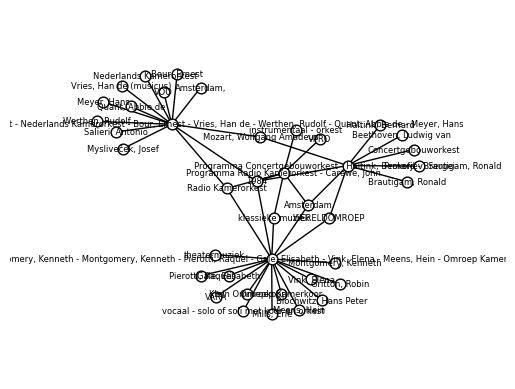

---------------------- Narrative # 2 ----------------------------
Concert :
Programma Lane, Elizabeth - Cable, Margaret - Thomas, David - Radio Kamerorkest - Parrott, Andrew

sdo:byArtist
Radio Kamerorkest
Thomas, David
Parrott, Andrew
Lane, Elizabeth
Cable, Margaret


sdo:datePublished
1984


sdo:genre
klassieke muziek
vocaal - twee of meer zangstemmen met orkest


sdo:provider
NCRV


The most important entity seems to be NCRV which was also was part of: 

Concert :
Programma Radio Kamerorkest - Carewe, John

sdo:byArtist
Radio Kamerorkest


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be klassieke muziek which was also was part of: 

Concert :
Programma Zieverink, Rob - Bogt, Rene te - Uitterlinden, Marjan - Brilleman, Inge

sdo:datePublished
1984


sdo:genre
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be 1984 which was also was part of: 

Concert :
Programma Gelders O

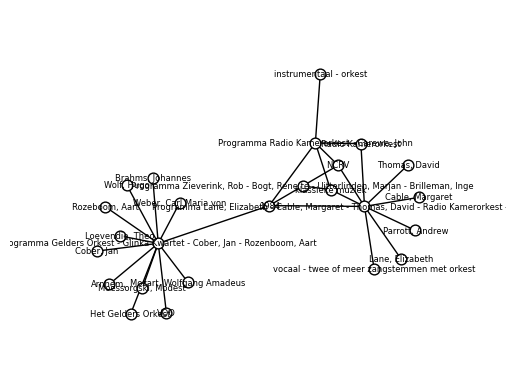

---------------------- Narrative # 3 ----------------------------
Concert :
Programma Radio Kamerorkest - Koopman, Ton

sdo:byArtist
Radio Kamerorkest
Koopman, Ton


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek
religieuze muziek


sdo:locationCreated
Amsterdam


sdo:provider
VARA


The most important entity seems to be instrumentaal - orkest which was also was part of: 

Concert :
Programma Radio Kamerorkest - Bour, Ernest

sdo:byArtist
Bour, Ernest
Radio Kamerorkest


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be Bour, Ernest which was also was part of: 

Concert :
Programma Klein Omroepkoor - Gritton, Robin - Radio Kamerorkest - Bour, Ernest

sdo:byArtist
Bour, Ernest
Radio Kamerorkest
Gritton, Robin
Klein Omroepkoor


sdo:datePublished
1984


sdo:genre
vocaal - koor met begeleiding
klassieke muziek
religieuze muziek


sdo:provider
NCRV


The most important entity se

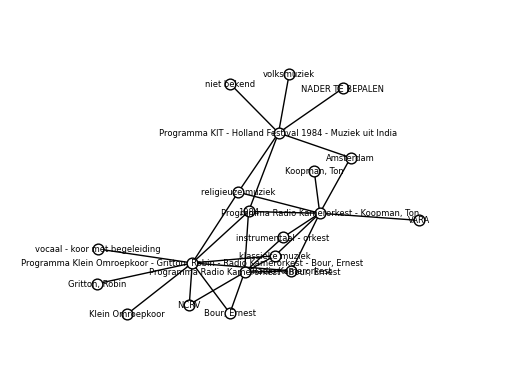

---------------------- Narrative # 4 ----------------------------
Concert :
Programma Lane, Elizabeth - Cable, Margaret - Thomas, David - Radio Kamerorkest - Parrott, Andrew

sdo:byArtist
Radio Kamerorkest
Thomas, David
Parrott, Andrew
Lane, Elizabeth
Cable, Margaret


sdo:datePublished
1984


sdo:genre
klassieke muziek
vocaal - twee of meer zangstemmen met orkest


sdo:provider
NCRV


The most important entity seems to be Parrott, Andrew which was also was part of: 

Concert :
Programma Radio Kamerorkest - Parrott, Andrew

sdo:byArtist
Radio Kamerorkest
Parrott, Andrew


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be Radio Kamerorkest which was also was part of: 

Concert :
Programma Radio Kamerorkest - Zender, Hans

sdo:byArtist
Radio Kamerorkest
Zender, Hans


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be Zen

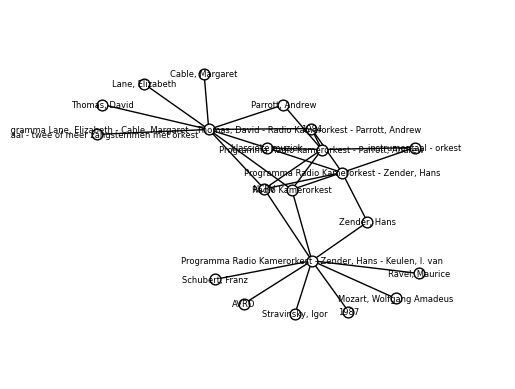

---------------------- Narrative # 5 ----------------------------
Concert :
Programma Blochwitz, Hans Peter - Mills, Erie - Montgomery, Kenneth - Montgomery, Kenneth - Pierotti, Raquel - Gale, Elisabeth - Vink, Elena - Meens, Hein - Omroep Kamerkoor - Klein Omroepkoor - Gritton, Robin - Radio Kamerorkest

sdo:byArtist
Radio Kamerorkest
Gritton, Robin
Klein Omroepkoor
Omroep Kamerkoor
Montgomery, Kenneth
Meens, Hein
Blochwitz, Hans Peter
Vink, Elena
Gale, Elisabeth
Pierotti, Raquel
Mills, Erie


sdo:datePublished
1984


sdo:genre
klassieke muziek
theatermuziek
vocaal - solo of soli met koor en orkest


sdo:locationCreated
Amsterdam


sdo:provider
WERELDOMROEP
VARA


The most important entity seems to be Montgomery, Kenneth which was also was part of: 

Concert :
Programma Blochwitz, Hans Peter - Mills, Erie - Montgomery, Kenneth - Montgomery, Kenneth - Pierotti, Raquel - Gale, Elisabeth - Vink, Elena - Meens, Hein - Omroep Kamerkoor - Klein Omroepkoor - Gritton, Robin - Radio Kamerorkes

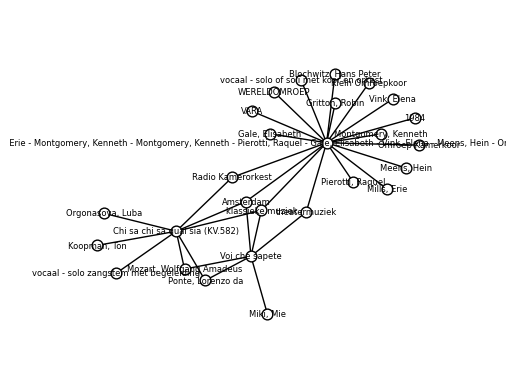

---------------------- Narrative # 6 ----------------------------
Concert :
Programma Frimmer, Monika - Dykstra, Hebe - Berne, Harry van - Heynsbergen, Henk van - Vera, Ana Maria - Groot Omroepkoor - Radio Kamerorkest - Oestman, Arnold

sdo:byArtist
Groot Omroepkoor
Radio Kamerorkest
Dijkstra, Hebe
Oestman, Arnold
Heijnsbergen, Henk van
Vera, Ana Maria
Berne, Harry van
Frimmer, Monika


sdo:creator
Mozart, Wolfgang Amadeus


sdo:datePublished
1991


sdo:locationCreated
AT&


sdo:provider
NCRV


The most important entity seems to be Groot Omroepkoor which was also was part of: 

Concert :
Vesperae Solemnes De Confessore (kv.339)

sdo:byArtist
Groot Omroepkoor
Bour, Ernest
Radio Kamerorkest
Crook, Howard
Oosterkamp, Wout
Lövaas, Kari


sdo:creator
Mozart, Wolfgang Amadeus


sdo:genre
klassieke muziek
religieuze muziek
vocaal - solo of soli met koor en orkest


sdo:locationCreated
Amsterdam


The most important entity seems to be vocaal - solo of soli met koor en orkest which was also was

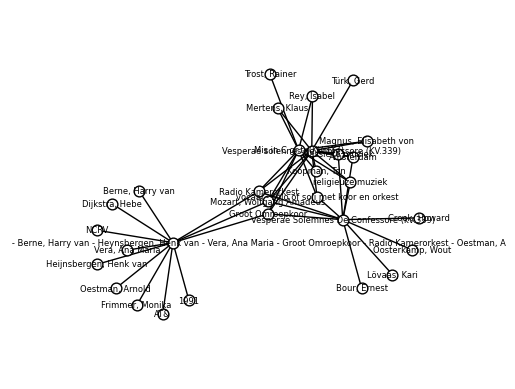

---------------------- Narrative # 7 ----------------------------
Concert :
Programma Radio Kamerorkest - Driesten, Roelof van

sdo:byArtist
Radio Kamerorkest
Driesten, Roelof van


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:locationCreated
Utrecht


sdo:provider
NCRV


The most important entity seems to be Driesten, Roelof van which was also was part of: 

Concert :
Programma Staalen, Marien van - Radio Kamerorkest - Driesten, Roelof van

sdo:byArtist
Radio Kamerorkest
Staalen, Marien van
Driesten, Roelof van


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be Staalen, Marien van which was also was part of: 

Concert :
Programma Staalen, Marien van - Radio Kamerorkest - Erdelyi, Miklos

sdo:byArtist
Radio Kamerorkest
Staalen, Marien van
Erdélyi, Miklós


sdo:datePublished
1984


sdo:genre
klassieke muziek
instrumentaal - strijkensembles


sdo:locationCreated
Vliss

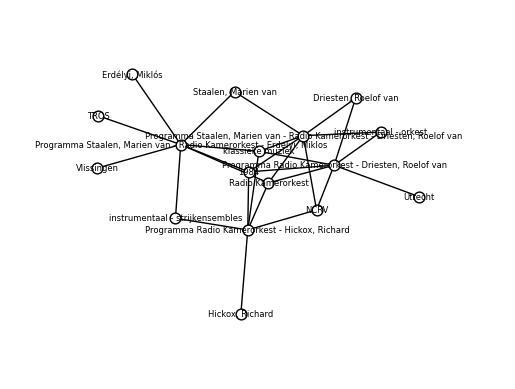

---------------------- Narrative # 8 ----------------------------
Concert :
Programma Winsemius, Bernard

sdo:byArtist
Winsemius, Bernard


sdo:datePublished
1984


sdo:genre
klassieke muziek
religieuze muziek
instrumentaal - 1 instrument


sdo:locationCreated
Amsterdam


sdo:provider
NCRV


The most important entity seems to be instrumentaal - 1 instrument which was also was part of: 

Concert :
Programma Benoist, Marjes

sdo:byArtist
Benoist, Marjès


sdo:datePublished
1984


sdo:genre
klassieke muziek
instrumentaal - 1 instrument


sdo:locationCreated
Amsterdam


sdo:provider
NCRV


The most important entity seems to be Benoist, Marjès which was also was part of: 

Concert :
Programma Benoist, Marjes

sdo:byArtist
Benoist, Marjès


sdo:datePublished
1984


sdo:genre
klassieke muziek
instrumentaal - 1 instrument


sdo:locationCreated
Amsterdam


sdo:provider
AVRO


The most important entity seems to be AVRO which was also was part of: 

Concert :
Programma Radio Kamerorkest - Bour, E

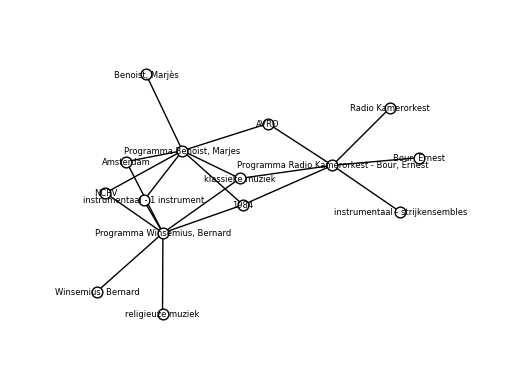

---------------------- Narrative # 9 ----------------------------
Concert :
Programma Radio Kamerorkest - Erdelyi, Miklos

sdo:byArtist
Radio Kamerorkest
Erdélyi, Miklós


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be Erdélyi, Miklós which was also was part of: 

Concert :
Programma Radio Kamerorkest - Erdelyi, Miklos

sdo:byArtist
Radio Kamerorkest
Erdélyi, Miklós


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:provider
NCRV


The most important entity seems to be NCRV which was also was part of: 

Concert :
Programma Radio Kamerorkest - Driesten, Roelof van

sdo:byArtist
Radio Kamerorkest
Driesten, Roelof van


sdo:datePublished
1984


sdo:genre
instrumentaal - orkest
klassieke muziek


sdo:locationCreated
Utrecht


sdo:provider
NCRV


The most important entity seems to be Utrecht which was also was part of: 

Concert :
Programma Radio Filh.Orkest - Radio Kamero

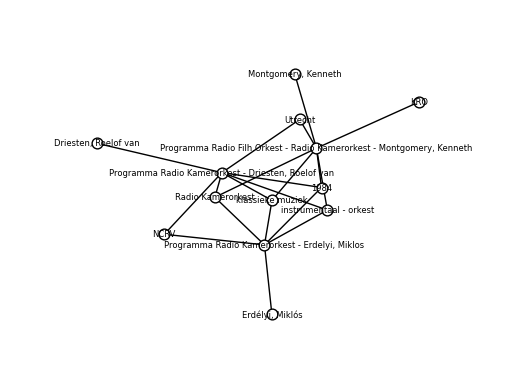

---------------------- Narrative # 10 ----------------------------
Concert :
Programma Rotterdams Ph.Orkest - Conlon, James - Merwe Hoorn, Martin v.d.

sdo:byArtist
Rotterdams Philharmonisch Orkest
Conlon, James


sdo:creator
Mozart, Wolfgang Amadeus
Haydn, Joseph
Gluck, Christoph Willibald von


sdo:datePublished
1984


sdo:locationCreated
De


sdo:provider
NOS


The most important entity seems to be Haydn, Joseph which was also was part of: 

Concert :
Programma Koten, Frank van - Jeurissen, Herman - Lier, Sonja van - Nyhuis, Annelies - Robert, Geraint - Groot Omroepkoor - Radio Kamerorkest - Montgomery, Kenneth

sdo:byArtist
Groot Omroepkoor
Radio Kamerorkest
Montgomery, Kenneth
Koten, Frank van
Lier, Sonja van
Jeurissen, Herman


sdo:creator
Mozart, Wolfgang Amadeus
Haydn, Joseph
Bree, Johannes van


sdo:datePublished
1990


sdo:locationCreated
VARA


sdo:provider
NCRV


The most important entity seems to be Koten, Frank van which was also was part of: 

Concert :
Programma Koten, 

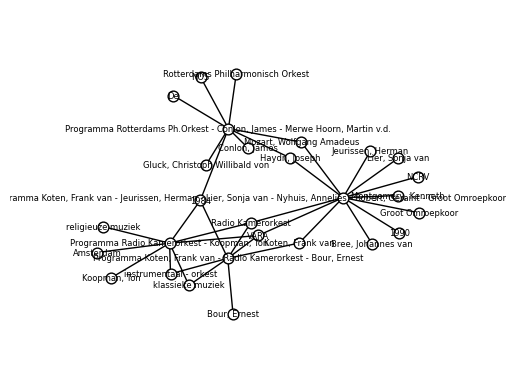

In [10]:
getNarratives()

In [90]:
# # MOZART AND METALLICA
# getPath(PersonGraph,'gtaa:134672','gtaa:61403')

# # BEETHOVAN AND METALLICA
# getPath(PersonGraph,'gtaa:80808','gtaa:61403')

Beethoven, Ludwig van
connected by sdo:creator with:
Koenig Stephan op.117
connected by sdo:byArtist with:
Groot Omroepkoor
connected by sdo:byArtist with:
The Living Room - A Circus of Angels
connected by sdo:creator with:
Bowie, David
connected by sdo:byArtist with:
Tribute to Freddie Mercury
connected by sdo:byArtist with:
Metallica


0.1419183669297076